# Invasive Ductal Cancer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

In [ ]:
# Running locally
X = np.load('../idc/data/X.npy')
y = np.load('../idc/data/Y.npy')

In [ ]:
# Running in Colab
X = np.load('/content/drive/MyDrive/Colab Notebooks/data/X.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/data/Y.npy')

In [ ]:
X.shape

(5547, 50, 50, 3)

In [ ]:
y.shape

(5547,)

## Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

X_scaled = X/255
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

# Instantiate image data generator
datagen = ImageDataGenerator(rotation_range=90, validation_split=0.3)

# Creates iterators for training images
val_images = datagen.flow(X_train, y_train, subset='validation', batch_size=32)
images = datagen.flow(X_train, y_train, subset='training', batch_size=32)

# Generates a fixed number of augmented images
# images, labels = next(datagen.flow(X_train, y_train, batch_size=X_train.shape[0]))

# # Merge original X_train with augmented images
# X_train = np.row_stack((X_train, images))
# X_train.shape
# 
# # Merge original y_train with augmented image labels
# y_train = np.hstack((y_train, labels))
# y_train.shape

## CNN Model Evaluation

In [ ]:
# Run only if you're not using data augmentation
# X_scaled = X/255
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

In [ ]:
# Final Model 1 (Based on Janowczyk and Madabhushi 2016)
# Recall:             0.849642
# Precision:          0.713426
# F1 score:           0.775599
# Balanced Accuracy:  0.751906

def init_model1(learning_rate=0.001):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(2,2), input_shape=(50, 50, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, kernel_size=(2,2), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, kernel_size=(2,2), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(64))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(16))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  optimizer = Adagrad(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', Recall(thresholds=0.35), Precision(thresholds=0.35)])
 
  return model

In [ ]:
# Final Model 3 (Elizabeth's version)
# Recall:             0.849642
# Precision:          0.729508
# F1 score:           0.785005
# Balanced Accuracy:  0.765207

def init_model3(learning_rate=0.001):
  model = models.Sequential()
  model.add(layers.Conv2D(100, kernel_size=(3,3), input_shape=(50, 50, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(200, kernel_size=(3,3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(16))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  optimizer = Adagrad(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', Recall(thresholds=0.45), Precision(thresholds=0.45)])
 
  return model

In [ ]:
model = init_model3()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 200)       180200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 24200)             0         
                                                                 
 dense (Dense)               (None, 16)                3

In [ ]:
# Training
# model = init_model3()
# mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5', 
#                      monitor='val_loss', mode='min', save_best_only=True)
# history = model.fit(images,
#           validation_data=val_images,
#           epochs=1000,
#           batch_size=64, 
#           verbose=1,
#           callbacks=mc)

In [ ]:
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

53/53 [==============================] - 6s 120ms/step - loss: 0.4862 - accuracy: 0.7730 - recall_1: 0.8974 - precision_1: 0.6861


[0.4861617088317871, 0.7729730010032654, 0.89737468957901, 0.6861313581466675]

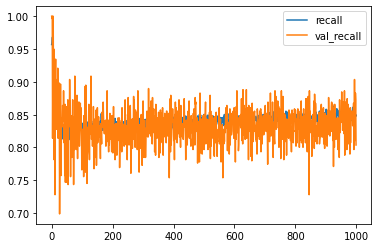

In [ ]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.legend()

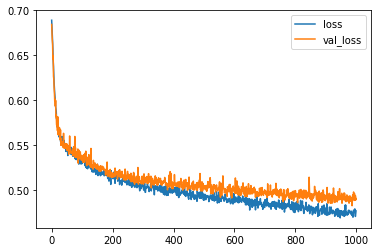

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

Precision Recall Curve

In [ ]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.51505839 0.51476015 0.51507692 0.51539409 0.51571165]
recall- [1.         0.99880668 0.99880668 0.99880668 0.99880668]
threshold- [0.07750788 0.07837304 0.07916176 0.07949072 0.08222136]


In [ ]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})
scores.head()

,threshold,precision,recall
0,0.077508,0.515058,1.000000
1,0.078373,0.514760,0.998807
2,0.079162,0.515077,0.998807
3,0.079491,0.515394,0.998807
4,0.082221,0.515712,0.998807


Text(0.5, 0, 'recall')

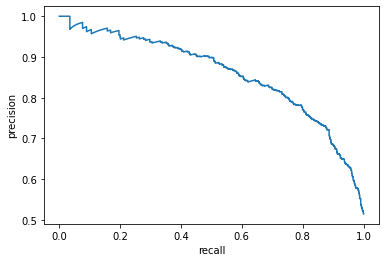

In [ ]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [ ]:
# Find threshold that guarantees 0.85 recall score
threshold = scores[scores['recall'] >= 0.85].threshold.max()
threshold

0.5076203346252441

Predict using test data

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
def binary_predict(y_pred, custom_threshold=0.45):
    return (y_pred > custom_threshold).astype(int)

updated_preds = binary_predict(y_pred, custom_threshold=threshold)

print(f'Recall:             {recall_score(y_test, updated_preds)}')
print(f'Precision:          {precision_score(y_test, updated_preds)}')
print(f'F1 score:           {f1_score(y_test, updated_preds)}')
print(f'Balanced Accuracy:  {balanced_accuracy_score(y_test, updated_preds)}')

Recall:             0.8496420047732697
Precision:          0.740894901144641
F1 score:           0.791550861589772
Balanced Accuracy:  0.7742768669573725


Save and load model

In [ ]:
# From Elizabeth's Colab Notebook
model.save('/content/drive/MyDrive/Colab Notebooks/model_final3.h5')

# Local save
# model.save('../models/model2.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/model_final3.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 100)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 200)       180200    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 24200)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               

Create model visualization

In [ ]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.1 MB/s 


In [ ]:
visualkeras.layered_view(model2, to_file='/content/drive/MyDrive/Colab Notebooks/model_final2_img.png').show()